In [14]:
# UNet2D Conditional Model for  Coloring

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')






In [15]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [16]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [17]:

# Project configuration
CONFIG = {
    'image_size': 64,  # Resize images to 64x64 for faster training
    'batch_size': 16,
    'learning_rate': 1e-4,
    'num_epochs': 100,
    'validation_split': 0.2,
    'num_classes': 9,  # Number of different colors
    'channels': 3,     # RGB channels
}

In [ ]:
# Custom Dataset Class for Conditional Polygon Coloring
class PolygonColoringDataset(Dataset):
    def __init__(self, data_path, split='training', transform=None):
        """
        Dataset for conditional polygon coloring
        Args:
            data_path: Path to dataset folder
            split: 'training' or 'validation'
            transform: Transforms to apply to images
        """
        self.data_path = data_path
        self.split = split
        self.transform = transform
        
        # Load data.json
        json_path = os.path.join(data_path, split, 'data.json')
        with open(json_path, 'r') as f:
            self.data = json.load(f)
        
        # Define color mapping
        self.color_map = {
            'red': 0, 'blue': 1, 'green': 2, 'yellow': 3,
            'orange': 4, 'purple': 5, 'cyan': 6, 'magenta': 7, 'black': 8
        }
        
        # Get unique colors from dataset
        colors_in_data = set()
        for item in self.data:
            colors_in_data.add(item['colour'])
        
        # Update color map with only colors present in dataset
        self.color_map = {color: idx for idx, color in enumerate(sorted(colors_in_data))}
        self.idx_to_color = {idx: color for color, idx in self.color_map.items()}
        
        print(f"Colors in {split} dataset: {list(self.color_map.keys())}")
        print(f"Number of samples in {split}: {len(self.data)}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Load input image (grayscale polygon)
        input_path = os.path.join(self.data_path, self.split, 'inputs', item['input_polygon'])
        input_img = Image.open(input_path).convert('RGB')
        
        # Load target image (colored polygon)
        output_path = os.path.join(self.data_path, self.split, 'outputs', item['output_image'])
        target_img = Image.open(output_path).convert('RGB')
        
        # Get color condition
        color_condition = self.color_map[item['colour']]
        
        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)
        
        return {
            'input': input_img,
            'target': target_img,
            'condition': torch.tensor(color_condition, dtype=torch.long),
            'color_name': item['colour']
        }



Colors in training dataset: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']
Number of samples in training: 56
Colors in validation dataset: ['blue', 'cyan', 'green', 'yellow']
Number of samples in validation: 5
Training samples: 56
Validation samples: 5
Number of color classes: 8


In [18]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])


In [19]:

# Create datasets
dataset_path = './dataset'
train_dataset = PolygonColoringDataset(dataset_path, split='training', transform=transform)
val_dataset = PolygonColoringDataset(dataset_path, split='validation', transform=transform)


Colors in training dataset: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']
Number of samples in training: 56
Colors in validation dataset: ['blue', 'cyan', 'green', 'yellow']
Number of samples in validation: 5


In [20]:

# Update config with actual number of classes
CONFIG['num_classes'] = len(train_dataset.color_map)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of color classes: {CONFIG['num_classes']}")

Training samples: 56
Validation samples: 5
Number of color classes: 8


In [3]:
# UNet2D Architecture with Conditional Input

class DoubleConv(nn.Module):
    """Double convolution block for UNet"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Handle padding if necessary
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class ConditionalUNet2D(nn.Module):
    """
    UNet2D with conditional input for color-based polygon generation
    """
    def __init__(self, n_channels=3, n_classes=3, num_conditions=8, bilinear=True):
        super(ConditionalUNet2D, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.num_conditions = num_conditions
        self.bilinear = bilinear
        
        # Condition embedding
        self.condition_embedding = nn.Embedding(num_conditions, 64)
        
        # Input convolution (includes condition channel)
        self.inc = DoubleConv(n_channels + 64, 64)  # +64 for condition embedding
        
        # Encoder
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        
        # Decoder
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        
        # Output convolution
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
    
    def forward(self, x, condition):
        # Embed condition
        batch_size, height, width = x.size(0), x.size(2), x.size(3)
        condition_emb = self.condition_embedding(condition)  # [batch_size, 64]
        condition_emb = condition_emb.unsqueeze(2).unsqueeze(3)  # [batch_size, 64, 1, 1]
        condition_emb = condition_emb.expand(-1, -1, height, width)  # [batch_size, 64, H, W]
        
        # Concatenate input with condition
        x = torch.cat([x, condition_emb], dim=1)  # [batch_size, 3+64, H, W]
        
        # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Decoder path with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # Output
        logits = self.outc(x)
        return torch.tanh(logits)  # Output in range [-1, 1]

# Initialize model
model = ConditionalUNet2D(
    n_channels=CONFIG['channels'],
    n_classes=CONFIG['channels'],
    num_conditions=CONFIG['num_classes'],
    bilinear=True
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model architecture: UNet2D with conditional input")
print(f"Input channels: {CONFIG['channels']}")
print(f"Output channels: {CONFIG['channels']}")
print(f"Number of conditions: {CONFIG['num_classes']}")

Total parameters: 13,432,835
Trainable parameters: 13,432,835
Model architecture: UNet2D with conditional input
Input channels: 3
Output channels: 3
Number of conditions: 8


In [4]:
# Data Loaders and Training Setup

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True, 
    num_workers=0,  # Set to 0 for Windows compatibility
    drop_last=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=0,
    drop_last=False
)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for image regression
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

# Training and validation loss tracking
train_losses = []
val_losses = []

def denormalize(tensor):
    """Denormalize tensor from [-1, 1] to [0, 1]"""
    return (tensor + 1) / 2

def visualize_batch(inputs, targets, predictions, conditions, color_names, epoch, batch_idx):
    """Visualize a batch of images"""
    batch_size = min(4, inputs.size(0))  # Show maximum 4 images
    
    fig, axes = plt.subplots(3, batch_size, figsize=(15, 8))
    if batch_size == 1:
        axes = axes.reshape(3, 1)
    
    for i in range(batch_size):
        # Denormalize images
        input_img = denormalize(inputs[i]).cpu().permute(1, 2, 0).numpy()
        target_img = denormalize(targets[i]).cpu().permute(1, 2, 0).numpy()
        pred_img = denormalize(predictions[i]).cpu().permute(1, 2, 0).numpy()
        
        # Clip values to [0, 1]
        input_img = np.clip(input_img, 0, 1)
        target_img = np.clip(target_img, 0, 1)
        pred_img = np.clip(pred_img, 0, 1)
        
        # Plot
        axes[0, i].imshow(input_img)
        axes[0, i].set_title(f'Input\\nCondition: {color_names[i]}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(target_img)
        axes[1, i].set_title('Target')
        axes[1, i].axis('off')
        
        axes[2, i].imshow(pred_img)
        axes[2, i].set_title('Prediction')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'Epoch {epoch}, Batch {batch_idx}', y=1.02)
    plt.show()

print("Training setup completed!")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Optimizer: Adam with learning rate {CONFIG['learning_rate']}")
print(f"Loss function: MSE Loss")
print(f"Scheduler: ReduceLROnPlateau")

Training setup completed!
Training batches: 3
Validation batches: 1
Optimizer: Adam with learning rate 0.0001
Loss function: MSE Loss
Scheduler: ReduceLROnPlateau


In [ ]:
# Training Loop

def train_epoch(model, train_loader, criterion, optimizer, epoch):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{CONFIG["num_epochs"]}')
    
    for batch_idx, batch in enumerate(progress_bar):
        inputs = batch['input'].to(device)
        targets = batch['target'].to(device)
        conditions = batch['condition'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs, conditions)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        # Visualize first batch of first epoch
        if epoch == 0 and batch_idx == 0:
            with torch.no_grad():
                visualize_batch(inputs, targets, outputs, conditions, 
                              batch['color_name'], epoch+1, batch_idx+1)
    
    return running_loss / len(train_loader)

def validate_epoch(model, val_loader, criterion, epoch):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)
            conditions = batch['condition'].to(device)
            
            # Forward pass
            outputs = model(inputs, conditions)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            
            # Visualize validation batch every 10 epochs
            if (epoch + 1) % 10 == 0 and batch_idx == 0:
                visualize_batch(inputs, targets, outputs, conditions, 
                              batch['color_name'], epoch+1, batch_idx+1)
    
    return running_loss / len(val_loader)

print("Training functions defined!")

Training functions defined!
Starting training...


Training for 100 epochs...


Epoch 1/100:   0%|          | 0/3 [00:01<?, ?it/s, Loss=0.8774]

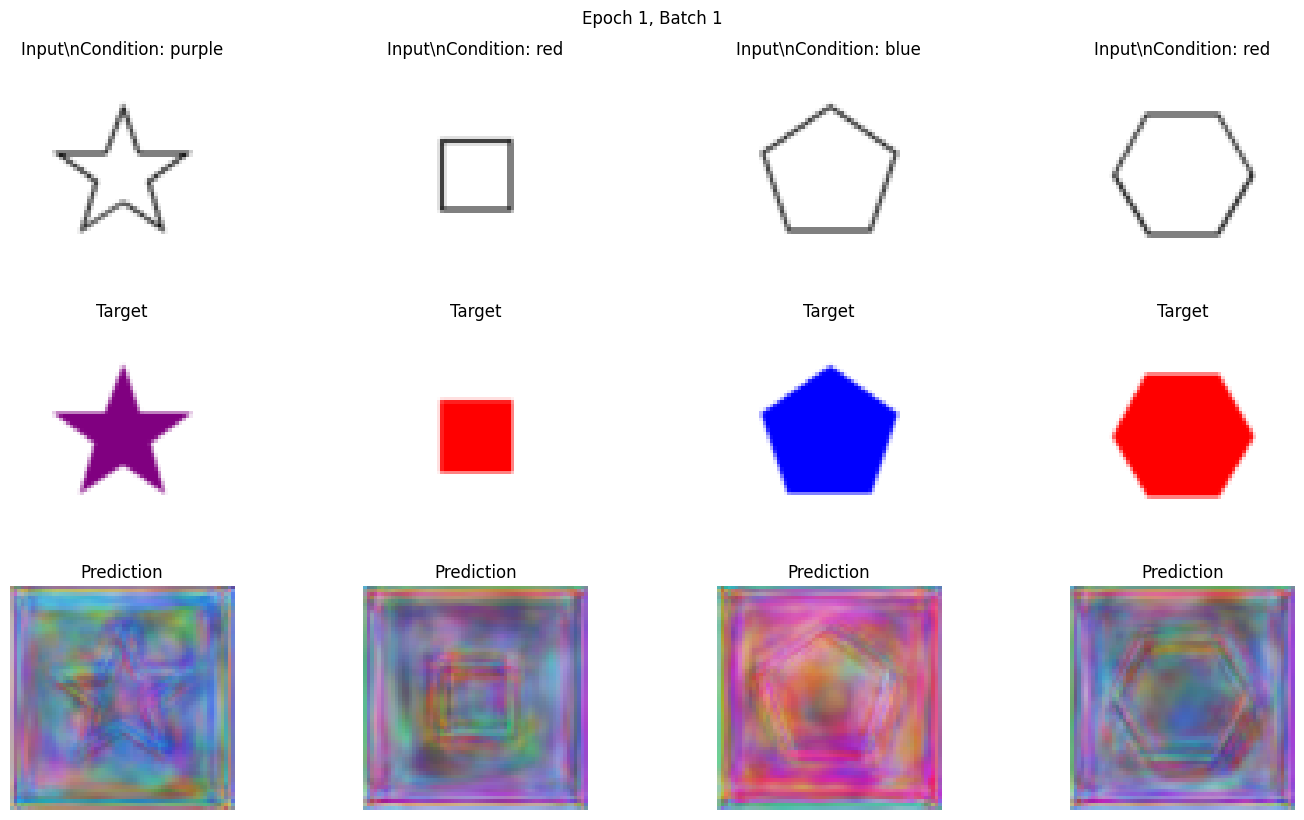

Epoch 1/100: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it, Loss=0.7864]


Epoch 1/100: Train Loss: 0.8359, Val Loss: 0.9557, LR: 0.000100
✓ New best model saved! Val Loss: 0.9557
------------------------------


Epoch 2/100: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, Loss=0.7257]


Epoch 2/100: Train Loss: 0.7045, Val Loss: 0.9383, LR: 0.000100
✓ New best model saved! Val Loss: 0.9383
------------------------------


Epoch 3/100: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, Loss=0.5986]


Epoch 3/100: Train Loss: 0.6034, Val Loss: 0.9060, LR: 0.000100
✓ New best model saved! Val Loss: 0.9060
------------------------------


Epoch 4/100: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it, Loss=0.6000]


Epoch 4/100: Train Loss: 0.5558, Val Loss: 0.8589, LR: 0.000100
✓ New best model saved! Val Loss: 0.8589
------------------------------


Epoch 5/100: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it, Loss=0.5174]


Epoch 5/100: Train Loss: 0.5096, Val Loss: 0.8023, LR: 0.000100
✓ New best model saved! Val Loss: 0.8023
------------------------------


Epoch 6/100: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it, Loss=0.4674]


Epoch 6/100: Train Loss: 0.4583, Val Loss: 0.7417, LR: 0.000100
✓ New best model saved! Val Loss: 0.7417
------------------------------


Epoch 7/100: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it, Loss=0.4422]


Epoch 7/100: Train Loss: 0.4468, Val Loss: 0.6674, LR: 0.000100
✓ New best model saved! Val Loss: 0.6674
------------------------------


Epoch 8/100: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, Loss=0.4434]


Epoch 8/100: Train Loss: 0.4379, Val Loss: 0.5901, LR: 0.000100
✓ New best model saved! Val Loss: 0.5901
------------------------------


Epoch 9/100: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, Loss=0.3432]


Epoch 9/100: Train Loss: 0.3639, Val Loss: 0.5174, LR: 0.000100
✓ New best model saved! Val Loss: 0.5174
------------------------------


Epoch 10/100: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it, Loss=0.3292]


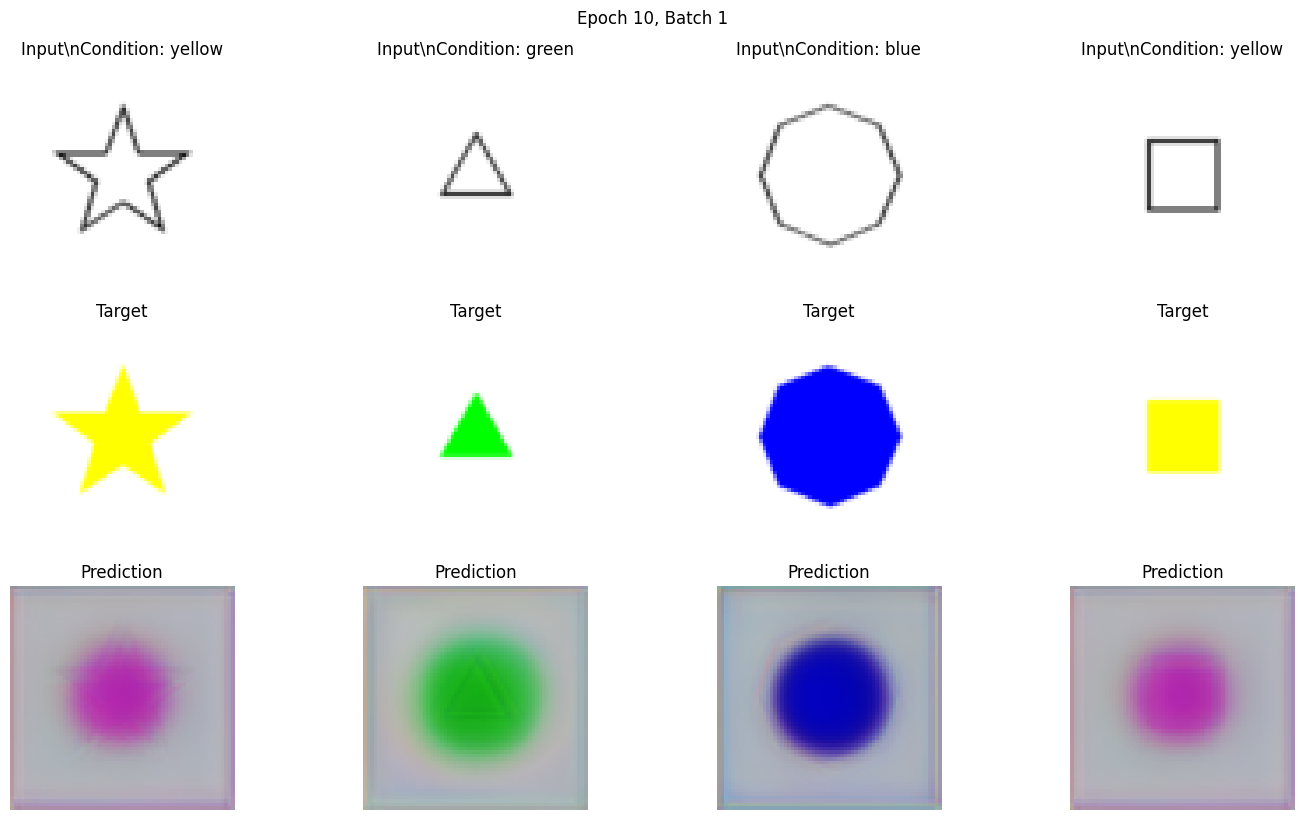

Epoch 10/100: Train Loss: 0.3618, Val Loss: 0.4873, LR: 0.000100
✓ New best model saved! Val Loss: 0.4873
------------------------------


Epoch 11/100: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it, Loss=0.3870]


Epoch 11/100: Train Loss: 0.3427, Val Loss: 0.4968, LR: 0.000100
------------------------------


Epoch 12/100: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it, Loss=0.3684]


Epoch 12/100: Train Loss: 0.3445, Val Loss: 0.4524, LR: 0.000100
✓ New best model saved! Val Loss: 0.4524
------------------------------


Epoch 13/100: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it, Loss=0.3056]


Epoch 13/100: Train Loss: 0.3059, Val Loss: 0.4030, LR: 0.000100
✓ New best model saved! Val Loss: 0.4030
------------------------------


Epoch 14/100: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it, Loss=0.2807]


Epoch 14/100: Train Loss: 0.2957, Val Loss: 0.3802, LR: 0.000100
✓ New best model saved! Val Loss: 0.3802
------------------------------


Epoch 15/100: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, Loss=0.3225]


Epoch 15/100: Train Loss: 0.2849, Val Loss: 0.4255, LR: 0.000100
------------------------------


Epoch 16/100: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, Loss=0.2398]


Epoch 16/100: Train Loss: 0.2780, Val Loss: 0.4592, LR: 0.000100
------------------------------


Epoch 17/100: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it, Loss=0.2657]


Epoch 17/100: Train Loss: 0.2794, Val Loss: 0.3824, LR: 0.000100
------------------------------


Epoch 18/100: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, Loss=0.2654]


Epoch 18/100: Train Loss: 0.2673, Val Loss: 0.2900, LR: 0.000100
✓ New best model saved! Val Loss: 0.2900
------------------------------


Epoch 19/100: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it, Loss=0.2810]


Epoch 19/100: Train Loss: 0.2468, Val Loss: 0.2771, LR: 0.000100
✓ New best model saved! Val Loss: 0.2771
------------------------------


Epoch 20/100: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it, Loss=0.2716]


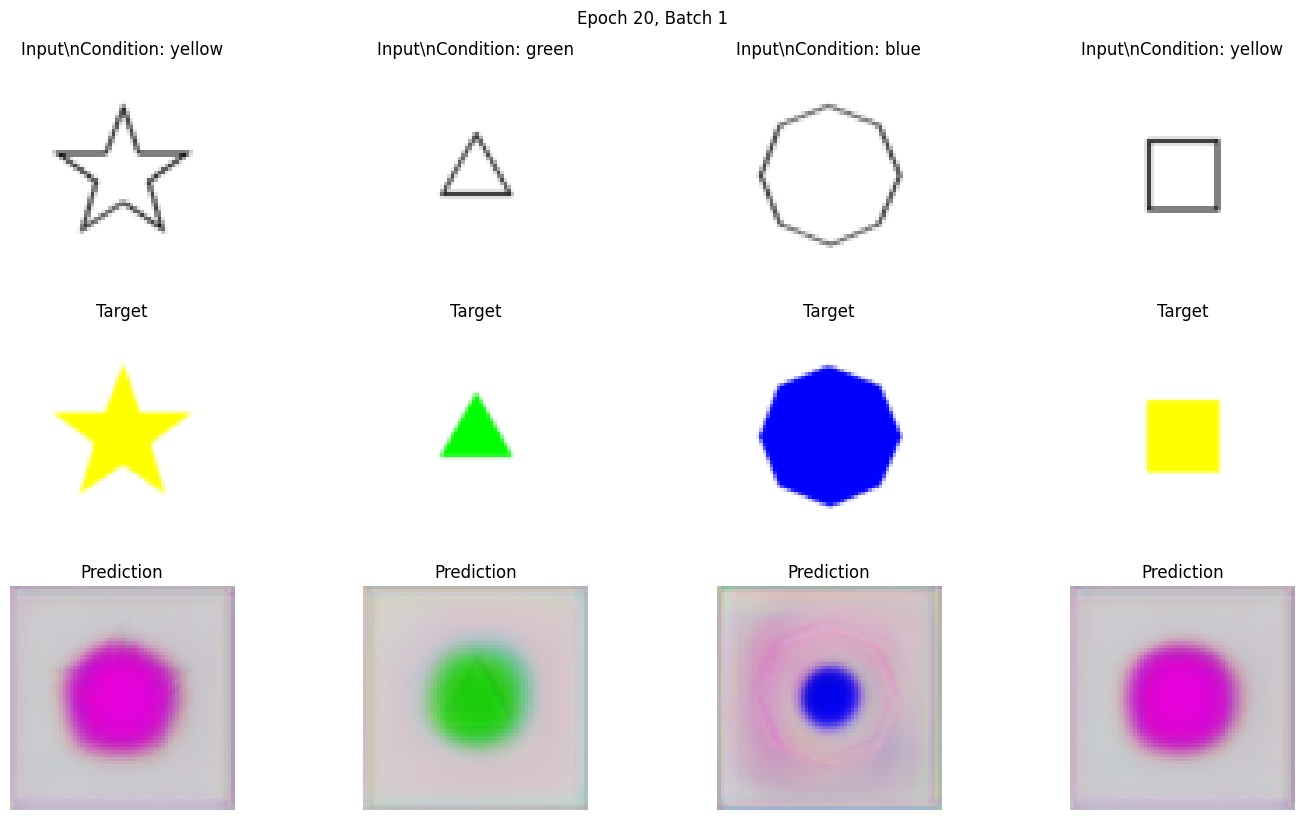

Epoch 20/100: Train Loss: 0.2474, Val Loss: 0.4099, LR: 0.000100
------------------------------


Epoch 21/100: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, Loss=0.2425]


Epoch 21/100: Train Loss: 0.2367, Val Loss: 0.3417, LR: 0.000100
------------------------------


Epoch 22/100: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it, Loss=0.2080]


Epoch 22/100: Train Loss: 0.2198, Val Loss: 0.3962, LR: 0.000100
------------------------------


Epoch 23/100: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it, Loss=0.2482]


Epoch 23/100: Train Loss: 0.2401, Val Loss: 0.3427, LR: 0.000100
------------------------------


Epoch 24/100: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, Loss=0.2186]


Epoch 24/100: Train Loss: 0.2258, Val Loss: 0.2352, LR: 0.000100
✓ New best model saved! Val Loss: 0.2352
------------------------------


Epoch 25/100: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it, Loss=0.2163]


Epoch 25/100: Train Loss: 0.2150, Val Loss: 0.2593, LR: 0.000100
------------------------------


Epoch 26/100: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it, Loss=0.1874]


Epoch 26/100: Train Loss: 0.1927, Val Loss: 0.3233, LR: 0.000100
------------------------------


Epoch 27/100: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it, Loss=0.2480]


Epoch 27/100: Train Loss: 0.1934, Val Loss: 0.2906, LR: 0.000100
------------------------------


Epoch 28/100: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it, Loss=0.2205]


Epoch 28/100: Train Loss: 0.1904, Val Loss: 0.2183, LR: 0.000100
✓ New best model saved! Val Loss: 0.2183
------------------------------


Epoch 29/100: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it, Loss=0.1748]


Epoch 29/100: Train Loss: 0.1811, Val Loss: 0.2862, LR: 0.000100
------------------------------


Epoch 30/100: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it, Loss=0.1860]


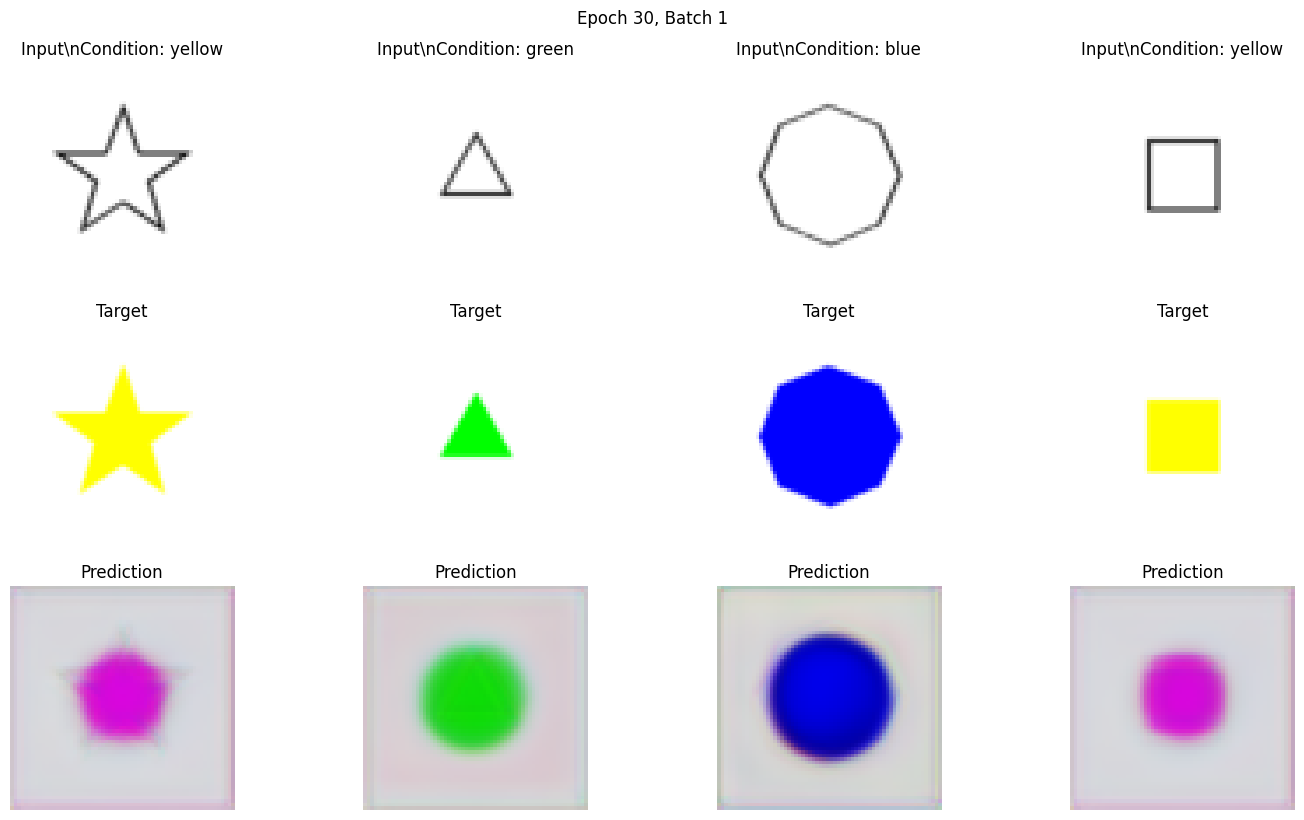

Epoch 30/100: Train Loss: 0.2052, Val Loss: 0.2474, LR: 0.000100
------------------------------


Epoch 31/100: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it, Loss=0.1688]


Epoch 31/100: Train Loss: 0.1813, Val Loss: 0.2308, LR: 0.000100
------------------------------


Epoch 32/100: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it, Loss=0.1987]


Epoch 32/100: Train Loss: 0.1746, Val Loss: 0.2728, LR: 0.000100
------------------------------


Epoch 33/100: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it, Loss=0.1544]


Epoch 33/100: Train Loss: 0.1683, Val Loss: 0.2608, LR: 0.000100
------------------------------


Epoch 34/100: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it, Loss=0.1545]


Epoch 34/100: Train Loss: 0.1645, Val Loss: 0.2368, LR: 0.000100
------------------------------


Epoch 35/100: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it, Loss=0.1673]


Epoch 35/100: Train Loss: 0.1610, Val Loss: 0.1672, LR: 0.000100
✓ New best model saved! Val Loss: 0.1672
------------------------------


Epoch 36/100: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it, Loss=0.1498]


Epoch 36/100: Train Loss: 0.1559, Val Loss: 0.1882, LR: 0.000100
------------------------------


Epoch 37/100: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it, Loss=0.1308]


Epoch 37/100: Train Loss: 0.1400, Val Loss: 0.2287, LR: 0.000100
------------------------------


Epoch 38/100: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it, Loss=0.1322]


Epoch 38/100: Train Loss: 0.1483, Val Loss: 0.2190, LR: 0.000100
------------------------------


Epoch 39/100: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, Loss=0.1659]


Epoch 39/100: Train Loss: 0.1552, Val Loss: 0.2116, LR: 0.000100
------------------------------


Epoch 40/100: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it, Loss=0.1209]


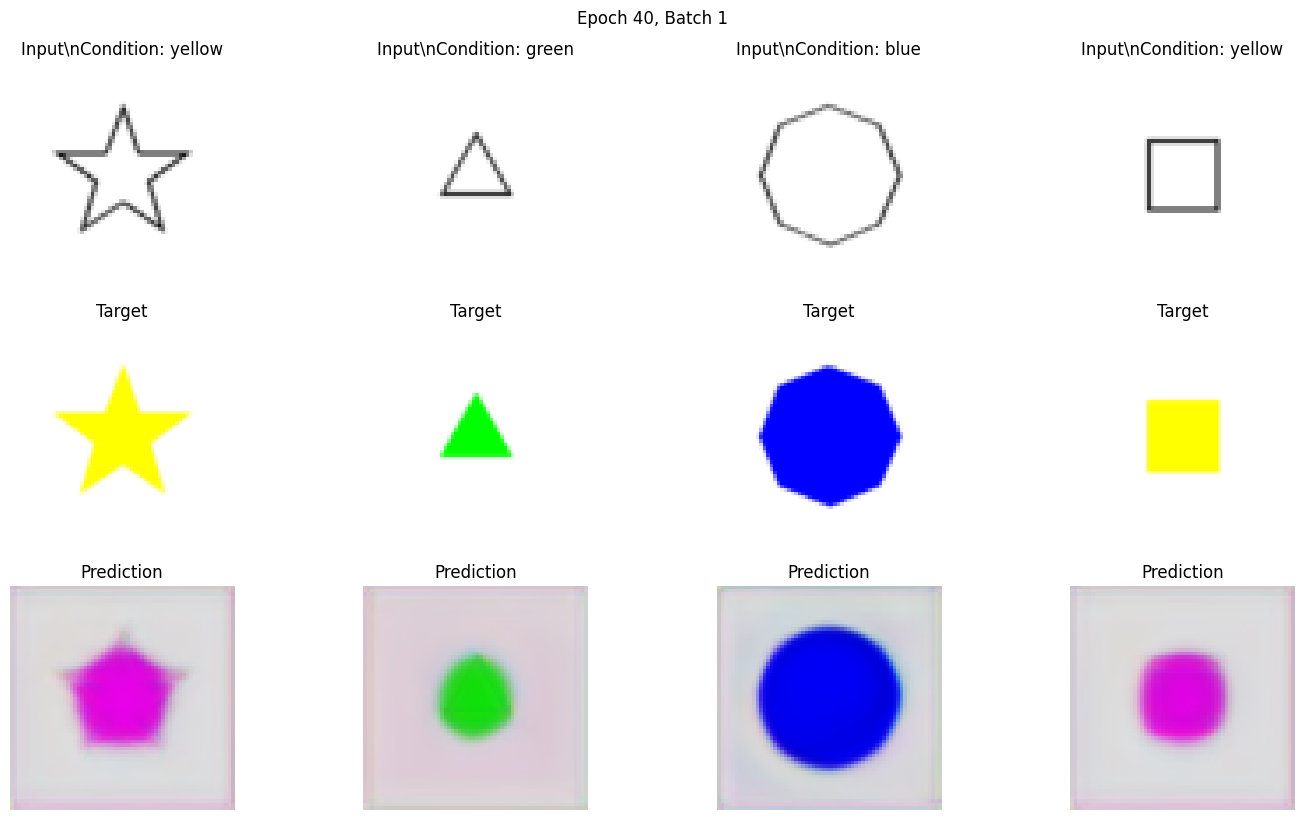

Epoch 40/100: Train Loss: 0.1354, Val Loss: 0.2169, LR: 0.000100
------------------------------


Epoch 41/100: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it, Loss=0.1390]


Epoch 41/100: Train Loss: 0.1354, Val Loss: 0.2136, LR: 0.000100
------------------------------


Epoch 42/100: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, Loss=0.1146]


Epoch 42/100: Train Loss: 0.1272, Val Loss: 0.2121, LR: 0.000100
------------------------------


Epoch 43/100: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it, Loss=0.1446]


Epoch 43/100: Train Loss: 0.1297, Val Loss: 0.2021, LR: 0.000100
------------------------------


Epoch 44/100: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, Loss=0.1202]


Epoch 44/100: Train Loss: 0.1209, Val Loss: 0.1972, LR: 0.000100
------------------------------


Epoch 45/100: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it, Loss=0.1287]


Epoch 45/100: Train Loss: 0.1203, Val Loss: 0.2053, LR: 0.000100
------------------------------


Epoch 46/100: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, Loss=0.1083]


Epoch 46/100: Train Loss: 0.1144, Val Loss: 0.1947, LR: 0.000050
------------------------------


Epoch 47/100: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it, Loss=0.1099]


Epoch 47/100: Train Loss: 0.1359, Val Loss: 0.1882, LR: 0.000050
------------------------------


Epoch 48/100: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, Loss=0.1089]


Epoch 48/100: Train Loss: 0.1101, Val Loss: 0.1847, LR: 0.000050
------------------------------


Epoch 49/100: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it, Loss=0.1704]


Epoch 49/100: Train Loss: 0.1310, Val Loss: 0.1834, LR: 0.000050
------------------------------


Epoch 50/100: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, Loss=0.1115]


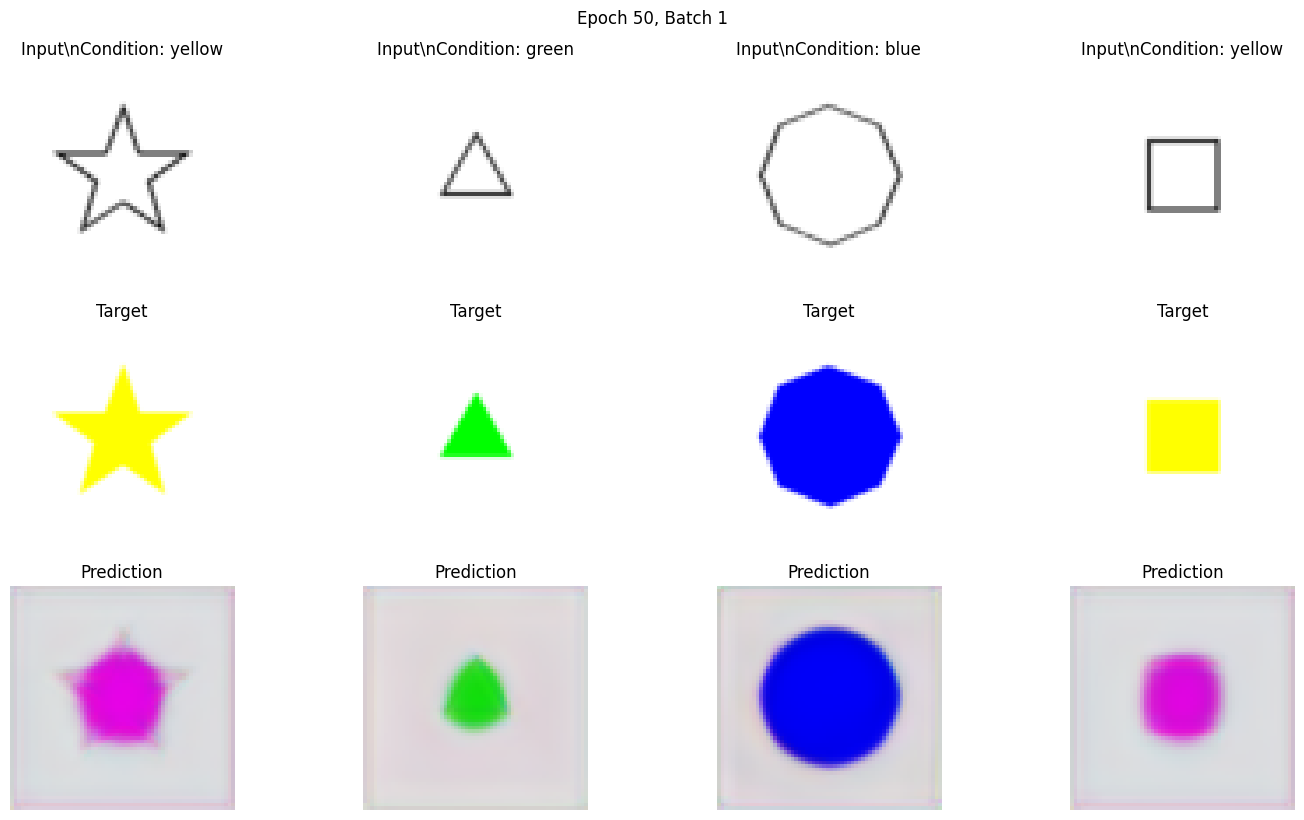

Epoch 50/100: Train Loss: 0.1174, Val Loss: 0.1797, LR: 0.000050
------------------------------


Epoch 51/100: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it, Loss=0.1063]


Epoch 51/100: Train Loss: 0.1079, Val Loss: 0.1785, LR: 0.000050
------------------------------


Epoch 52/100: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, Loss=0.1068]


Epoch 52/100: Train Loss: 0.1018, Val Loss: 0.1783, LR: 0.000050
------------------------------


Epoch 53/100: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it, Loss=0.1156]


Epoch 53/100: Train Loss: 0.1363, Val Loss: 0.1859, LR: 0.000050
------------------------------


Epoch 54/100: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it, Loss=0.1294]


Epoch 54/100: Train Loss: 0.1115, Val Loss: 0.1888, LR: 0.000050
------------------------------


Epoch 55/100: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it, Loss=0.1250]


Epoch 55/100: Train Loss: 0.1107, Val Loss: 0.1822, LR: 0.000050
Early stopping triggered after 55 epochs
\nTraining completed!
Best validation loss: 0.1672
Final model saved!


In [6]:
# Main Training Loop

best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 20

# Create directory for saving models
os.makedirs('models', exist_ok=True)

print(f"Training for {CONFIG['num_epochs']} epochs...")
print("=" * 50)

for epoch in range(CONFIG['num_epochs']):
    # Training
    train_loss = train_epoch(model, train_loader, criterion, optimizer, epoch)
    train_losses.append(train_loss)
    
    # Validation
    val_loss = validate_epoch(model, val_loader, criterion, epoch)
    val_losses.append(val_loss)
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    # Print epoch results
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}: "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")
    
    # Early stopping and model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'config': CONFIG,
            'color_map': train_dataset.color_map
        }, 'models/best_model.pth')
        print(f"✓ New best model saved! Val Loss: {val_loss:.4f}")
    else:
        patience_counter += 1
    
    # Early stopping check
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break
    
    print("-" * 30)

print("\\nTraining completed!")
print(f"Best validation loss: {best_val_loss:.4f}")

# Save final model
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
    'config': CONFIG,
    'color_map': train_dataset.color_map
}, 'models/final_model.pth')
print("Final model saved!")

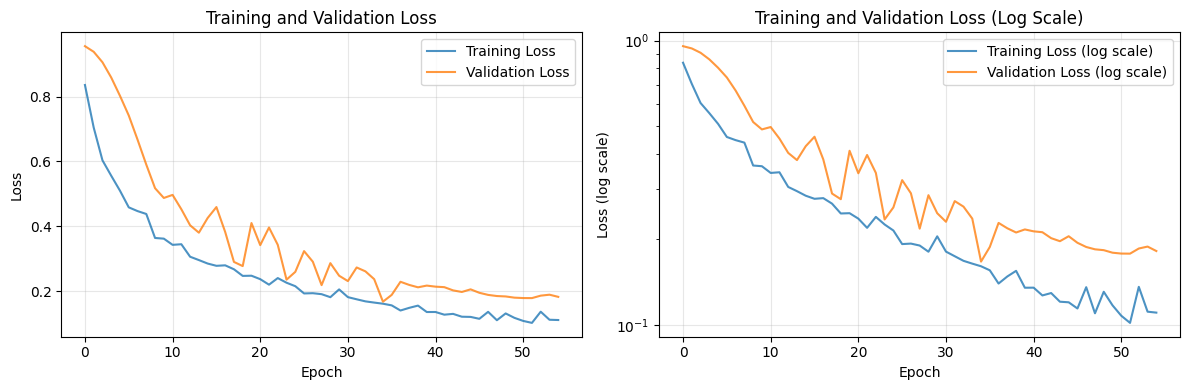

Training completed after 55 epochs
Final training loss: 0.1107
Final validation loss: 0.1822
Best validation loss: 0.1672
\n==================================================
MODEL PERFORMANCE SUMMARY
Best Validation Loss: 0.1672
Training Epochs: 55
Model Parameters: 13,432,835
Dataset Size: 56 training, 5 validation
Color Classes: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']


In [7]:
# Plot Training Curves and Evaluation

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss (log scale)', alpha=0.8)
plt.plot(val_losses, label='Validation Loss (log scale)', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training and Validation Loss (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Training completed after {len(train_losses)} epochs")
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")

# Performance summary
print("\\n" + "="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Training Epochs: {len(train_losses)}")
print(f"Model Parameters: {total_params:,}")
print(f"Dataset Size: {len(train_dataset)} training, {len(val_dataset)} validation")
print(f"Color Classes: {list(train_dataset.color_map.keys())}")
print("="*50)

Best model loaded successfully!
Available colors: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']


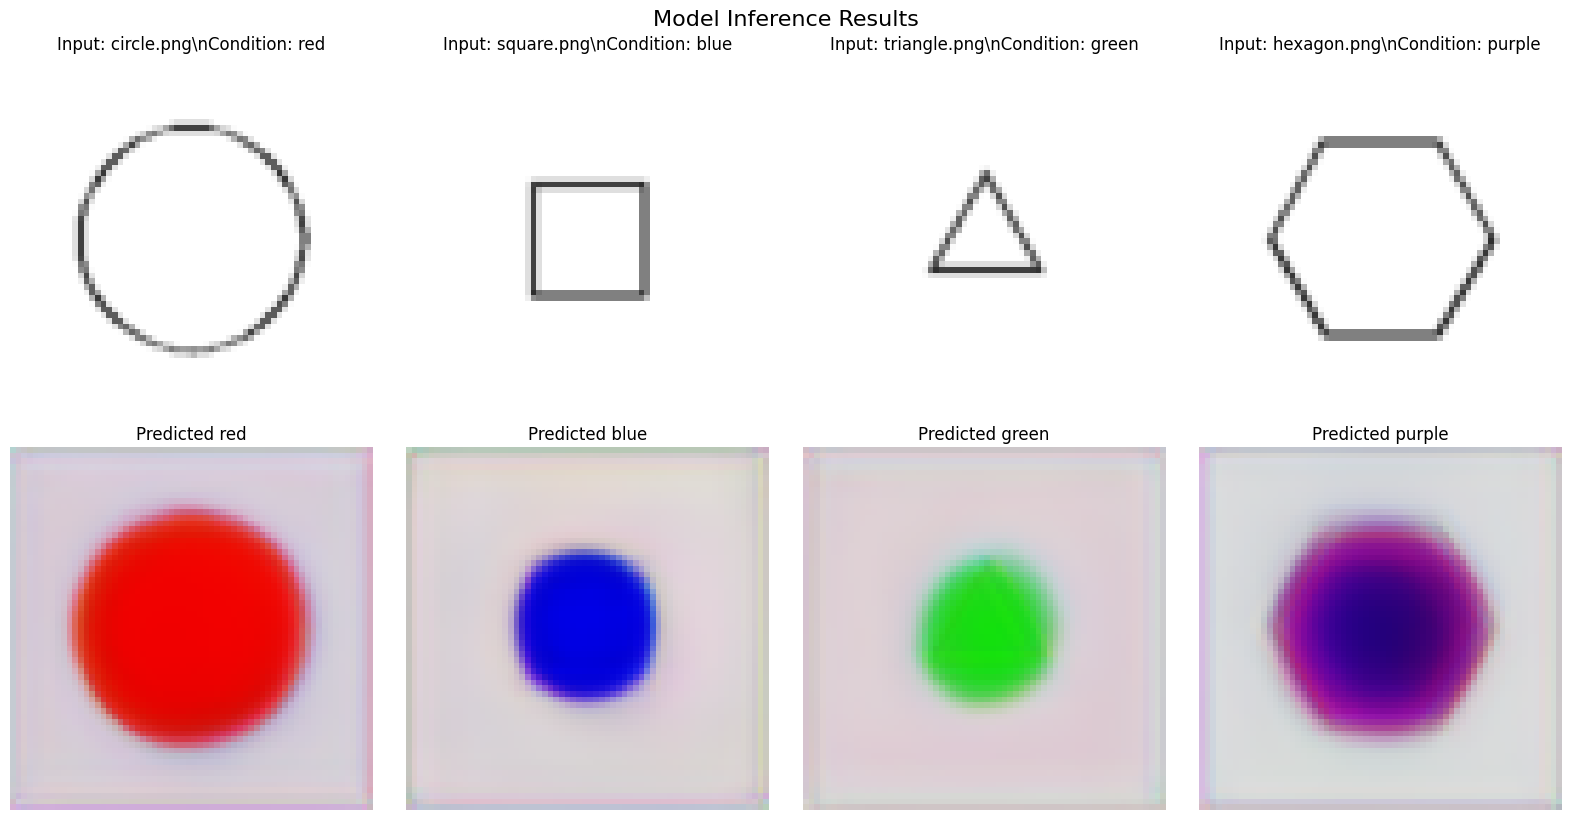

\nInference testing completed!


In [8]:
# Model Inference and Testing

def load_best_model(model_path='models/best_model.pth'):
    """Load the best trained model"""
    checkpoint = torch.load(model_path, map_location=device)
    
    # Create model with saved configuration
    loaded_model = ConditionalUNet2D(
        n_channels=checkpoint['config']['channels'],
        n_classes=checkpoint['config']['channels'],
        num_conditions=checkpoint['config']['num_classes'],
        bilinear=True
    ).to(device)
    
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.eval()
    
    return loaded_model, checkpoint['color_map']

def predict_single_image(model, input_image_path, color_condition, color_map, transform):
    """Predict colored output for a single input image"""
    model.eval()
    
    # Load and preprocess image
    img = Image.open(input_image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Get color condition index
    if isinstance(color_condition, str):
        condition_idx = color_map[color_condition]
    else:
        condition_idx = color_condition
    
    condition_tensor = torch.tensor([condition_idx], dtype=torch.long).to(device)
    
    # Predict
    with torch.no_grad():
        prediction = model(img_tensor, condition_tensor)
    
    # Convert to numpy for visualization
    input_np = denormalize(img_tensor[0]).cpu().permute(1, 2, 0).numpy()
    prediction_np = denormalize(prediction[0]).cpu().permute(1, 2, 0).numpy()
    
    input_np = np.clip(input_np, 0, 1)
    prediction_np = np.clip(prediction_np, 0, 1)
    
    return input_np, prediction_np

# Load the best model
best_model, saved_color_map = load_best_model()
print("Best model loaded successfully!")
print(f"Available colors: {list(saved_color_map.keys())}")

# Test on some training images with different color conditions
test_cases = [
    ('dataset/training/inputs/circle.png', 'red'),
    ('dataset/training/inputs/square.png', 'blue'),
    ('dataset/training/inputs/triangle.png', 'green'),
    ('dataset/training/inputs/hexagon.png', 'purple'),
]

plt.figure(figsize=(16, 8))

for i, (img_path, color) in enumerate(test_cases):
    if color in saved_color_map:
        input_img, predicted_img = predict_single_image(
            best_model, img_path, color, saved_color_map, transform
        )
        
        # Plot input
        plt.subplot(2, len(test_cases), i+1)
        plt.imshow(input_img)
        plt.title(f'Input: {os.path.basename(img_path)}\\nCondition: {color}')
        plt.axis('off')
        
        # Plot prediction
        plt.subplot(2, len(test_cases), i+1+len(test_cases))
        plt.imshow(predicted_img)
        plt.title(f'Predicted {color}')
        plt.axis('off')
    else:
        print(f"Color '{color}' not available in model")

plt.tight_layout()
plt.suptitle('Model Inference Results', y=1.02, fontsize=16)
plt.show()

print("\\nInference testing completed!")